In [1]:
import numpy as np
import librosa
import soundfile as sf
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.signal import lfilter, freqz
from scipy.linalg import toeplitz

In [2]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wavfile
import speech_recognition as sr
import wave  # used for writing the WAV file.

In [3]:
class SpeechProcessor:
    def __init__(self, duration=5, fs=44100):
        """
        Initialize the SpeechProcessor with recording parameters.
        :param duration: Duration of the audio to record in seconds.
        :param fs: Sampling rate (Hz) for the recording.
        """
        self.duration = duration
        self.fs = fs
        self.recognizer = sr.Recognizer()  # Initialize the recognizer
        self.audio_file = None  # Will store the path to the recorded file

    def record_speech(self):
        """
        Record audio for a specified duration using sounddevice and save it as a 16-bit PCM WAV.
        """
        try:
            print("Recording...")
            audio = sd.rec(int(self.duration * self.fs), samplerate=self.fs, channels=1, dtype='int16')  # Save as 16-bit PCM
            sd.wait()  # Wait until recording is finished
            print("Recording finished.")
            
            # Save the recorded audio as a 16-bit PCM WAV file
            self.audio_file = 'YourAudio.wav'
            with wave.open(self.audio_file, 'wb') as wf:
                wf.setnchannels(1)  # Mono channel 
                wf.setsampwidth(2)  # 2 bytes = 16 bits
                wf.setframerate(self.fs)
                wf.writeframes(audio.tobytes())  # Convert to bytes and write to file

            return self.audio_file  # Return the filename for further processing

        except sd.PortAudioError as e:
            print(f"Error recording audio: {e}")
            return None

        except Exception as e:
            print(f"Unexpected error occurred during recording: {e}")
            return None

    def convert_speech_to_text(self):
        """
        Convert recorded audio file to text using Google's Web Speech API.
        """
        if not self.audio_file:
            print("No audio file recorded yet.")
            return None

        try:
            # Use recognizer to open and recognize the speech in the wav file
            with sr.AudioFile(self.audio_file) as source:
                audio = self.recognizer.record(source)  # Record the audio from the file
            print("Recognizing...")
            text = self.recognizer.recognize_google(audio)
            print(f"Speech recognized: {text}")
            return text

        except sr.UnknownValueError:
            print("Speech Recognition could not understand audio. Please try speaking more clearly.")
            return None

        except sr.RequestError:
            print("Could not connect to the recognition service. Please check your internet connection.")
            return None

        except FileNotFoundError:
            print("The recorded audio file could not be found.")
            return None

        except Exception as e:
            print(f"An unexpected error occurred during speech recognition: {e}")
            return None

    def get_audio_file(self):
        """
        Returns the file path of the recorded audio file.
        """
        if self.audio_file:
            return self.audio_file
        else:
            print("No audio has been recorded yet.")
            return None

    def display_text(self, text):
        """
        Display the recognized text.
        """
        if text:
            print(f'Speech successfully converted to text: "{text}"')
        else:
            print("Speech conversion failed.")

    def process(self):
        """
        The main process that records audio, converts to text, and displays the result.
        """
        # Step 1: Record the speech
        audio_file = self.record_speech()
        
        if audio_file:
            # Step 2: Convert the recorded audio to text
            text = self.convert_speech_to_text()
            
            # Step 3: Display the converted text
            self.display_text(text)
        else:
            print("Audio recording failed, cannot proceed with speech recognition.")

'''# Example of how to use the SpeechProcessor class
if __name__ == "__main__":
    try:
        processor = SpeechProcessor(duration=5)  # Set the desired duration
        processor.record_speech()  # Record the speech
        
        # Attempt to retrieve the audio file
        audio_file = processor.get_audio_file()
        if audio_file:
            print(f"Audio file saved at: {audio_file}")
        else:
            print("Audio file retrieval failed.")

    except Exception as e:
        print(f"An unexpected error occurred during the process: {e}")'''

'# Example of how to use the SpeechProcessor class\nif __name__ == "__main__":\n    try:\n        processor = SpeechProcessor(duration=5)  # Set the desired duration\n        processor.record_speech()  # Record the speech\n        \n        # Attempt to retrieve the audio file\n        audio_file = processor.get_audio_file()\n        if audio_file:\n            print(f"Audio file saved at: {audio_file}")\n        else:\n            print("Audio file retrieval failed.")\n\n    except Exception as e:\n        print(f"An unexpected error occurred during the process: {e}")'

In [4]:
def get_audio_choice():
    choice = input("Do you want to record a new speech signal or upload a file? (record/upload): ").strip().lower()
    
    if choice == 'record':
        try:
            processor = SpeechProcessor(duration=5)  # Set the desired duration
            processor.record_speech()  # Record the speech
            
            # Attempt to retrieve the audio file
            audio_file = processor.get_audio_file()
            if audio_file:
                print(f"Audio file saved at: {audio_file}")
                # Load the saved audio file back as an AudioSegment
                audio = AudioSegment.from_wav(audio_file)
                return audio
            else:
                print("Audio file retrieval failed.")
                return None

        except Exception as e:
            print(f"An unexpected error occurred during the process: {e}")
            return None
    
    elif choice == 'upload':
        filepath = input("Please enter the path of the speech file to upload: ")
        try:
            audio = AudioSegment.from_file(filepath)
            print(f"Loaded audio from {filepath}")
            return audio
        except Exception as e:
            print(f"Error loading the file. Make sure the path is correct. {e}")
            return None
    else:
        print("Invalid choice. Please choose either 'record' or 'upload'.")
        return None


In [5]:
# LPC Analysis Function
def lpc_analysis(signal, fs, order=12):
    # Apply pre-emphasis filter to boost high frequencies
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    
    # Calculate autocorrelation of the signal
    autocorr = np.correlate(emphasized_signal, emphasized_signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    
    # Build the Toeplitz matrix from autocorrelation
    R = toeplitz(autocorr[:order])
    r = autocorr[1:order + 1]
    
    # Solve the linear system
    lpc_coeffs = np.linalg.solve(R, r)
    lpc_coeffs = np.insert(lpc_coeffs, 0, 1)  # Insert 1 for the LPC filter
    
    # Filter the signal to reconstruct
    filtered_signal = lfilter([0] + -lpc_coeffs[1:], [1], signal)
    
    return lpc_coeffs, filtered_signal



In [6]:
# Function to estimate formants from LPC coefficients
def estimate_formants(lpc_coeffs, fs):
    roots = np.roots(lpc_coeffs)
    roots = [r for r in roots if np.imag(r) >= 0]  # Keep only positive roots
    
    angles = np.angle(roots)
    frequencies = sorted(angles * (fs / (2 * np.pi)))
    
    formants = []
    for f in frequencies:
        if f > 90 and f < fs / 2:  # Frequency range typical for formants
            formants.append(f)
    
    return formants



In [7]:
# Plot function for LPC and reconstructed signal
def plot_signals(signal, reconstructed_signal, fs):
    plt.figure(figsize=(12, 6))
    time_axis = np.linspace(0, len(signal) / fs, num=len(signal))
    
    # Plot original signal
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, signal)
    plt.title('Original Speech Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Plot reconstructed signal
    plt.subplot(2, 1, 2)
    plt.plot(time_axis, reconstructed_signal)
    plt.title('Reconstructed Speech Signal (from LPC)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()



In [8]:
# Plot formant frequencies
def plot_formants(formants):
    plt.figure(figsize=(8, 4))
    plt.stem(formants)  # Removed 'use_line_collection'
    plt.title('Formant Frequencies')
    plt.xlabel('Formant Number')
    plt.ylabel('Frequency (Hz)')
    plt.grid(True)
    plt.show()




Loaded audio from /Users/christina/Desktop/CHRIST /GITHUB/Speech-Processing/Lab 4-/YourAudio.wav


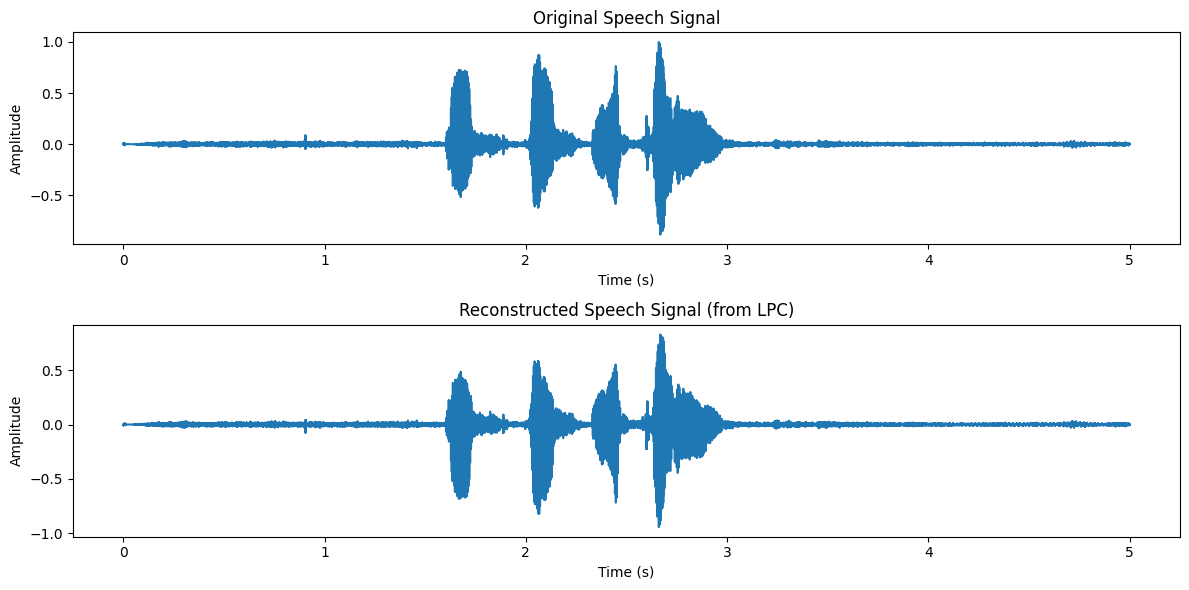

Estimated Formants: [np.float64(3743.5339428253646), np.float64(7271.692954157768), np.float64(11599.950345201298), np.float64(13559.541885149772), np.float64(18077.108976958938)]


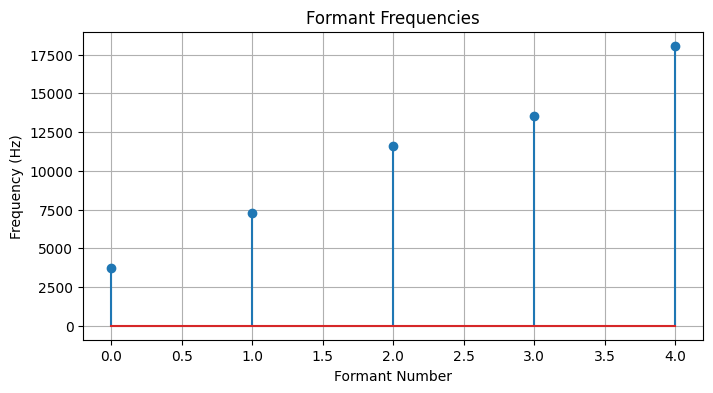

Reconstructed signal saved as 'reconstructed_signal.wav'


In [9]:
# Main execution
if __name__ == "__main__":
    audio = get_audio_choice()
    
    if audio:
        # Convert audio to numpy array for processing
        audio_samples = np.array(audio.get_array_of_samples())
        fs = audio.frame_rate  # Sampling rate
        
        # Normalize the signal
        signal = audio_samples / np.max(np.abs(audio_samples))
        
        # Perform LPC analysis
        lpc_order = 12  # You can experiment with different LPC orders
        lpc_coeffs, reconstructed_signal = lpc_analysis(signal, fs, lpc_order)
        
        # Plot original and reconstructed signals
        plot_signals(signal, reconstructed_signal, fs)
        
        # Estimate formants from LPC coefficients
        formants = estimate_formants(lpc_coeffs, fs)
        print(f"Estimated Formants: {formants}")
        
        # Plot the formant frequencies
        plot_formants(formants)
        
        # Optionally save the reconstructed signal
        sf.write('reconstructed_signal.wav', reconstructed_signal, fs)
        print("Reconstructed signal saved as 'reconstructed_signal.wav'")

### Brief Note/Inference on LPC Model Implementation

The Linear Predictive Coding (LPC) model is commonly used in speech signal processing for analyzing and reconstructing speech signals. The implementation of the LPC model in this context involves the following key steps and insights:

1. **Formant Frequency Analysis**:
   - The formant frequencies plot indicates the dominant resonant frequencies in the speech signal. These formants are crucial in determining the unique characteristics of spoken sounds.
   - The plot shows the formant frequencies derived from the LPC coefficients. Higher formants (F1, F2, etc.) reflect the resonance patterns in the vocal tract that shape specific sounds.

2. **Speech Signal Reconstruction**:
   - The second plot compares the **Original Speech Signal** with the **Reconstructed Speech Signal** using LPC.
   - The reconstructed signal retains the overall shape and timing of the original signal but may differ slightly in amplitude or fine details due to the approximation nature of LPC.
   - The similarity between the two waveforms demonstrates that the LPC model has successfully captured the essential features of the original speech signal.

3. **Inference**:
   - LPC is effective for compressing speech signals and extracting the essential characteristics that define the vocal tract's configuration during speech production.
   - The analysis highlights that LPC can be used for tasks such as speech synthesis, recognition, and formant analysis, making it a versatile tool in speech processing.
   - The reconstructed signal's quality indicates the model's effectiveness, and minor differences are expected due to the approximation and noise factors inherent in the speech signal.

This implementation demonstrates the ability of LPC to model and reconstruct speech signals, providing a strong foundation for applications in speech recognition and synthesis.

### Brief Note/Inference on LPC Model Implementation with Input Audio: 'This is a chair'

The Linear Predictive Coding (LPC) model was implemented to analyze and reconstruct the audio signal from the input phrase, **'This is a chair'**. Here are the key observations and insights:

1. **Formant Frequency Analysis**:
   - The formant frequency plot shows the primary resonant frequencies in the speech signal corresponding to the input phrase, **'This is a chair'**. These formants are critical in characterizing the specific sounds of the spoken words.
   - The distinct peaks in the plot represent the resonances that shape the unique qualities of each phoneme in the phrase. For example, vowels like the 'i' in 'this' and 'a' in 'chair' have distinct formant structures.

2. **Speech Signal Reconstruction**:
   - The second plot compares the **Original Speech Signal** of the phrase **'This is a chair'** with its **Reconstructed Speech Signal** using LPC.
   - The reconstructed signal closely follows the original waveform, retaining the general shape and timing of the spoken phrase, though there may be minor variations due to the approximations inherent in the LPC process.
   - The reconstructed output preserves the rhythm and intonation of the original phrase, indicating the model’s ability to capture the essential characteristics of the speech.

3. **Inference**:
   - The LPC model effectively compresses the speech signal and extracts the key features that define the vocal tract's configuration while producing the phrase **'This is a chair'**.
   - The similarity between the original and reconstructed signals shows that LPC can successfully retain the audio's intelligibility and key characteristics, making it suitable for applications like speech synthesis and recognition.
   - Despite minor variations between the original and reconstructed signals, the overall quality demonstrates the effectiveness of LPC in representing the phrase, allowing for analysis of speech patterns and phonemes.

This analysis of the input **'This is a chair'** highlights the capability of LPC to model speech signals, making it a valuable tool for understanding and reconstructing spoken language.